In [8]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt

directory = 'data/odis_json'
over = []
wickets_left = []
batter_runs = []
total_runs = []
batter = []
bowler = []
season_list = []


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and '.json' in f:
        jsonFile = json.load(open(f))
        season = str(jsonFile['info']['season'])
        for inning in jsonFile['innings']:
            current_wickets_left = 10
            for o in inning['overs']:
                current_over = o['over']
                for delivery in o['deliveries']:
                    over.append(current_over)
                    wickets_left.append(current_wickets_left)
                    batter_runs.append(delivery['runs']['batter'])
                    total_runs.append(delivery['runs']['total'])
                    batter.append(delivery['batter'])
                    bowler.append(delivery['bowler'])
                    season_list.append(season)
                    if 'wickets' in delivery:
                        current_wickets_left -= len(delivery['wickets'])

runs = pd.DataFrame()
runs['over'] = over
runs['wickets_left'] = wickets_left
runs['batter_runs'] = batter_runs
runs['total_runs'] = total_runs
runs['batter'] = batter
runs['bowler'] = bowler
runs['season'] = season_list

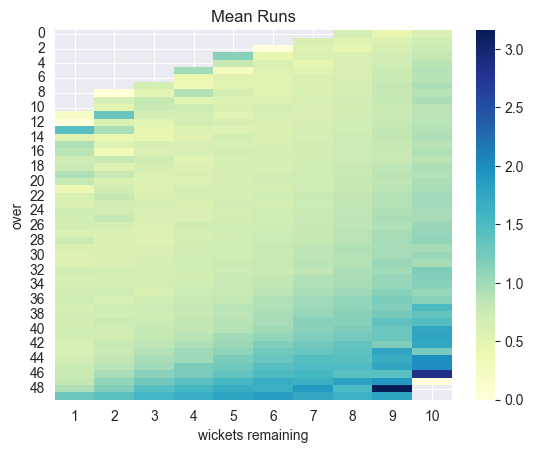

In [9]:
import seaborn as sns

mat = np.empty((50, 10))
for over in range(50):
    for wickets_left in range(10):
        if len(runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]) > 0:
            mat[over, wickets_left] = runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]['total_runs'].mean()
        else:
            mat[over, wickets_left] = np.NaN


data = pd.DataFrame(mat)
data.columns = range(1, 11)
data = data.rename_axis('over', axis=0).rename_axis('wickets remaining', axis=1)

ax = sns.heatmap(data, fmt=".2f", cmap="YlGnBu", square = False)
plt.xticks(np.arange(0.5, 10.5, 1), np.arange(1, 11, 1))
plt.yticks(np.arange(0.5, 50.5, 2), np.arange(0, 50, 2))
plt.title('Mean Runs')

plt.show()
expectancy_matrix = data.to_numpy()

In [10]:
expected_runs_per_play = []
runs['expected_runs'] = runs.apply((lambda row: expectancy_matrix[row['over']][row['wickets_left'] - 1]), axis=1)
runs['runs_above_average'] = runs['total_runs'] - runs['expected_runs']

In [11]:
TR_above_average_batter = runs.groupby(['batter', 'season'])['runs_above_average'].mean() * runs.groupby(['batter', 'season']).size()
TR_above_average_batter = TR_above_average_batter.reset_index()
TR_above_average_batter.rename(columns={0: 'BaTRAA'}, inplace = True)
TR_above_average_batter.sort_values(by = 'BaTRAA', ascending = False)

,batter,season,BaTRAA
366,AB de Villiers,2014/15,406.188370
11427,V Sehwag,2008/09,318.929322
2465,DA Warner,2016/17,289.201260
2474,DA Warner,2023/24,284.797016
1439,BB McCullum,2014/15,277.925581
...,...,...,...
8554,R Dravid,2002/03,-148.737719
9898,SM Katich,2005/06,-178.437020
9256,S Chanderpaul,2006/07,-179.360074
3253,Fargana Hoque,2023/24,-212.991198


In [12]:
TR_above_average_bowler = -1 * runs.groupby(['bowler', 'season'])['runs_above_average'].mean() * runs.groupby(['bowler', 'season']).size()
TR_above_average_bowler = TR_above_average_bowler.reset_index()
TR_above_average_bowler.rename(columns={0: 'BoTRAA'}, inplace = True)
TR_above_average_bowler.sort_values(by = 'BoTRAA', ascending = False)

,bowler,season,BoTRAA
6970,SM Pollock,2006/07,266.126992
6795,SE Bond,2006/07,210.506102
7273,Saeed Ajmal,2011/12,207.605232
4432,M Muralitharan,2002/03,206.792806
7277,Saeed Ajmal,2013/14,196.724906
...,...,...,...
4718,MJ McClenaghan,2013/14,-143.935032
3073,J Little,2023,-191.556759
4358,M Jansen,2023/24,-201.077088
5432,NLTC Perera,2014/15,-224.058062


ValueError: The data contains non-finite values.

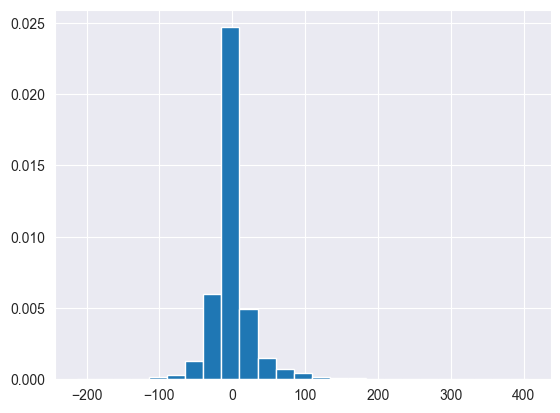

In [13]:
from scipy.stats import norm

to_plot = TR_above_average_batter['BaTRAA']
plt.hist(to_plot, bins = 25, density = True)

mu, std = norm.fit(to_plot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pdf_scaled = norm.pdf(x, mu, std)

plt.plot(x, pdf_scaled, 'k', linewidth=2)

plt.title('Freq of BaTRAA')
plt.xlabel('BaTRAA')
plt.ylabel('Frequency')

plt.show()

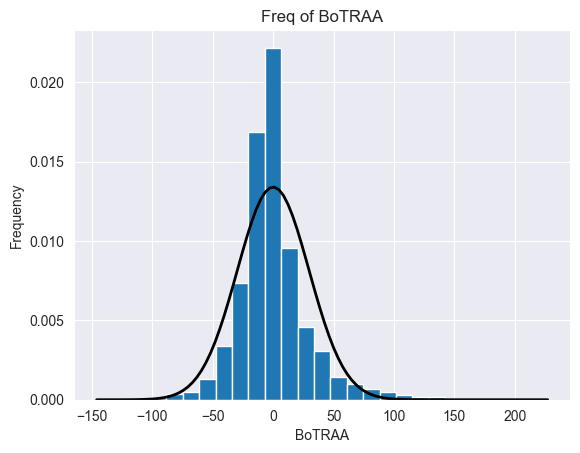

In [7]:
to_plot = TR_above_average_bowler['BoTRAA']
plt.hist(to_plot, bins = 25, density = True)

mu, std = norm.fit(to_plot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pdf_scaled = norm.pdf(x, mu, std)

plt.plot(x, pdf_scaled, 'k', linewidth=2)

plt.title('Freq of BoTRAA')
plt.xlabel('BoTRAA')
plt.ylabel('Frequency')

plt.show()